In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
from Bio import SeqIO
from model import CouplingsModel

In [3]:
### 1. sample from MCMC with Metropolis Hastings
###     Underlying distribution: AA only depends on previous position. Probability matrix of alphabets based on war_and_peace.txt
### 2. Create a2m files from the samples
### 3. Train a potts model with plmc
### 4. Observe dependency matrices
np.random.seed(0)
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'

1. Sampling Sequences with MCMC

In [4]:
### first learn the conditional probabilities
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

freq_matrix = build_bigram_freq_matrix(input_file)

### freq_matrix is based on all 26 letters of the english alphabet + space
### map the matrix to protein alphabets
indices = []
for aa in list(ALPHABET_PROTEIN):
    if aa == '-':
        indices.append(26)
    else:
        indices.append(ord(aa)-ord('A'))


In [5]:
protein_freq_matrix = freq_matrix[indices]
protein_freq_matrix = protein_freq_matrix[:, indices]

### normalize it so probabilities sum to 1
for x in protein_freq_matrix:
    x /= np.sum(x)

### check for valid probabilities

assert np.all(protein_freq_matrix >= 0) and np.all(protein_freq_matrix <= 1)

In [6]:
np.sum(protein_freq_matrix)

21.0

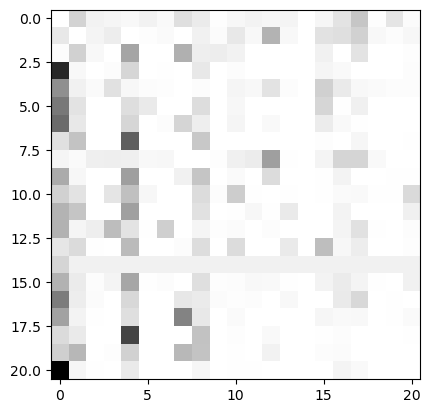

In [7]:
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    

In [69]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    result = []
    cur = init_func()
    new_state = True
    for i in range(num_iters):
        candidate = proposal_func(cur)
        score = score_func(cur, candidate)
        if score >= 1:
            cur = candidate
        else:
            r = np.random.rand()
            if r <= score:
                cur = candidate
                new_state = True
        if (i%step == 0 and new_state):
            result.append(cur)
            new_state = False
    return result

In [70]:
SEQ_LEN = 15
## initialize random starting state
def init_state():
    starting_state = ''.join(np.random.choice(list(ALPHABET_PROTEIN)) for _ in range(SEQ_LEN))
    return list(starting_state)

def sample_candidate(sample):
    """
    randomly mutate 2 aa's
    """
    idx1 = np.random.randint(0, SEQ_LEN)
    idx2 = np.random.randint(0, SEQ_LEN)
    sample2 = np.copy(sample)

    sample2[idx1] = np.random.choice(list(ALPHABET_PROTEIN))
    sample2[idx2] = np.random.choice(list(ALPHABET_PROTEIN))
    return sample2


def scorer(current_sample, candidate):
    """
    Calculate the acceptance probability of the sequence
    """
    result = 1
    for i in range(SEQ_LEN - 1):
        first_x = ALPHABET_PROTEIN.index(current_sample[i])
        second_x = ALPHABET_PROTEIN.index(current_sample[i+1])

        first_y = ALPHABET_PROTEIN.index(candidate[i])
        second_y = ALPHABET_PROTEIN.index(candidate[i+1])
        fxi = protein_freq_matrix[first_x][second_x]
        fyi = protein_freq_matrix[first_y][second_y]
        result = result + np.log(fyi) - np.log(fxi)
    return min(1, np.exp(result))

In [74]:
samples = metropolis_hastings(sample_candidate, init_state, scorer, 100000)

In [87]:
for index,seq in enumerate(samples):
    print(index)
    print(''.join(seq))

0
TWKQ-FGVTYESRKM
1
ENIGIFSFTHEEHMA
2
ENIKYASE-CTT-TE
3
QVIENGSE-ATT-SE
4
N-KNAH-A-S-F-ST
5
H-KNCT-E-MANCAT
6
HEICCY-E-HANEAW
7
GE-CCKFR-HAN-A-
8
GESCCKER-HANCA-
9
KESPRRED-HANCAH
10
NESH-PEY-HANEAT
11
IATM-MEY-HAL-AD
12
ECTIF-VN-S-Y-LT
13
QCTISK-E-THV-LL
14
G-TRSKEESTNG-AV
15
F-T-NKESETRY-AT
16
E-AR-TLIERES-CT
17
Y-AR-TLDESAF-AI
18
Y-PR-TIRA-DS-TI
19
Y-DR-TIRA-CS-HI
20
N-WA-CIMIEGECRI
21
D-WDICIMIEWAWNE
22
D-HILLIMMEEADGE
23
Y-LILY-WMETWEPE
24
P-WILK-WIGAR-TE
25
MILFIK-NIGARSME
26
TIT-IK-SI-GRSTE
27
TINDAW-SM-GRSTY
28
MINMAY-NC-TRS-T
29
PINMAY-TD-DRR-W
30
PRVIA-E-T-ENY-F
31
PATSHISAT-IAD-P
32
TATSHINET-INF-D
33
CATSVINETHENV-S
34
WICACAMSTHEVIRN
35
WITACAMSTHETEWH
36
TISYCINSTHECA-H
37
GINLP-CATHECA-A
38
GINNS-CAWHEPAIM
39
MA-IS-FAWHEPAIM
40
MA-YS-NAWHEVAIM
41
MPELS-H-WHER-EP
42
QAYWE-F-WETAREL
43
QH-TE-G-METAIEW
44
SHETENG-RERANEY
45
SHETENG-KADNGE-
46
GHILENKASAGNSMI
47
GHIREN-GSIRKIMI
48
SWIREN-GS-VLIMI
49
S-IREFATE-ILIEV
50
R-ITEEART-IDIER
51
M-ITEQACK-IDIE-
52
M-QMEFA-T-ILRE-
53


In [89]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = (SeqRecord(Seq(''.join(seq)), str(index)) for index,seq in enumerate(samples) )
with open("simulation/example.a2m", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")

In [91]:
samples[0]

['T', 'W', 'K', 'Q', '-', 'F', 'G', 'V', 'T', 'Y', 'E', 'S', 'R', 'K', 'M']

In [90]:
### training code for model
!plmc/bin/plmc -o simulation/example.model_params -c simulation/example.txt -f 0 -le 2.8 -lh 0.01 -m 200 -t 0.2 -g simulation/example.a2m

Found focus 0 as sequence 1
2844 valid sequences out of 2844 
14 sites out of 15
Effective number of samples (to 1 decimal place): 2810.0	(80% identical neighborhood = 1.000 samples)
iter	time	cond	fx	-loglk	||h||	||e||
1	0.0	77.63	87830.3	87758.8	12.1	5.0
2	0.0	52.65	77560.9	71457.9	14.6	46.7
3	0.1	21.75	74748.1	63926.2	11.8	62.2
4	0.1	14.84	69010.6	62119.2	11.4	49.6
5	0.1	8.63	67662.7	61984.7	11.6	45.0
6	0.1	7.08	67158.4	61305.8	11.8	45.7
7	0.1	6.09	66657.2	60157.6	11.8	48.2
8	0.1	12.34	66255.5	56832.5	11.9	58.0
9	0.1	4.93	65734.2	56315.3	12.0	58.0
10	0.1	2.63	65577.9	56878.8	11.9	55.7
11	0.2	1.74	65485.5	56934.8	12.0	55.3
12	0.2	2.19	65391.7	56728.0	12.0	55.6
13	0.2	1.62	65320.6	56438.9	12.1	56.3
14	0.2	2.20	65299.8	56225.9	12.1	56.9
15	0.2	0.96	65275.1	56183.4	12.1	57.0
16	0.2	0.79	65260.3	56137.3	12.1	57.1
17	0.2	0.74	65247.8	56041.6	12.2	57.3
18	0.2	0.85	65243.5	55998.5	12.2	57.5
19	0.2	0.44	65238.9	55949.6	12.2	57.6
20	0.3	0.35	65235.7	55923.1	12.2	57.7
21	0.3	0.39	65232.5	55908

In [93]:
c = CouplingsModel(f"simulation/example.model_params")

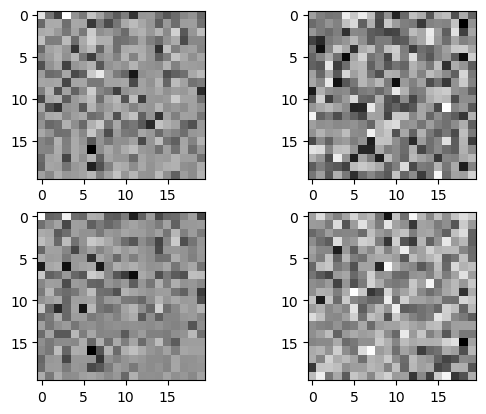

In [101]:
plt.subplot(2, 2, 1)
plt.imshow(c.J_ij[0][1], cmap='binary', interpolation='none')

plt.subplot(2, 2, 2)
plt.imshow(c.J_ij[0][2], cmap='binary', interpolation='none')
plt.subplot(2, 2, 3)
plt.imshow(c.J_ij[1][2], cmap='binary', interpolation='none')
plt.subplot(2, 2, 4)
plt.imshow(c.J_ij[1][5], cmap='binary', interpolation='none')

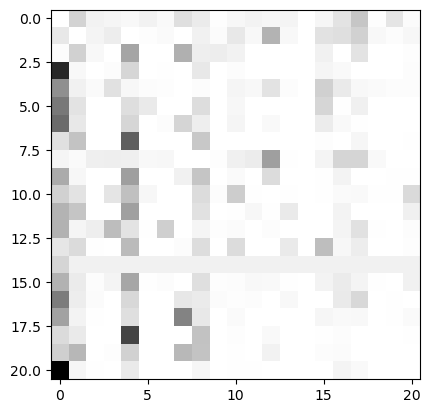

In [97]:
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    


In [103]:
c.h_i.shape

(14, 20)

In [104]:
c.h_i[:, 1]

array([-0.49141422, -0.5851566 , -0.3507052 , -0.5098023 , -0.55405617,
       -0.00954543, -0.11106441,  0.00415905, -0.507703  , -0.25792542,
       -0.3243008 , -0.51190615, -0.58782977, -0.33034942], dtype=float32)

In [105]:
c.h_i[:, 3]

array([0.2343509, 2.1396394, 1.3340632, 1.3567048, 1.5578519, 1.3548737,
       1.4124703, 0.6755996, 1.4249932, 1.6689664, 1.5004754, 1.0989776,
       1.5842409, 1.0038882], dtype=float32)